In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

사용할 데이터셋을 불러옵니다. 이번 시간에는 stanford_dogs 데이터셋을 사용해보도록 합시다. stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

데이터를 처음 사용한다면 다운로드해야 하기 때문에 시간이 오래(10분 이상) 걸릴 수 있습니다. 당황하지 마시고 잠시 휴식 시간을 가져 보세요. 데이터셋은 다른 프로젝트에서도 사용할 수 있으니 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장합시다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


In [4]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

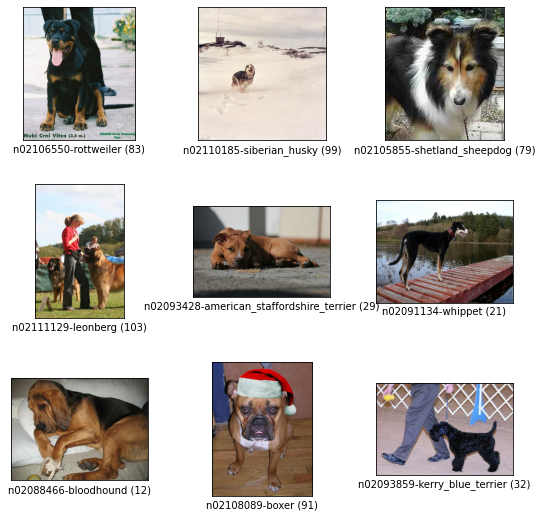

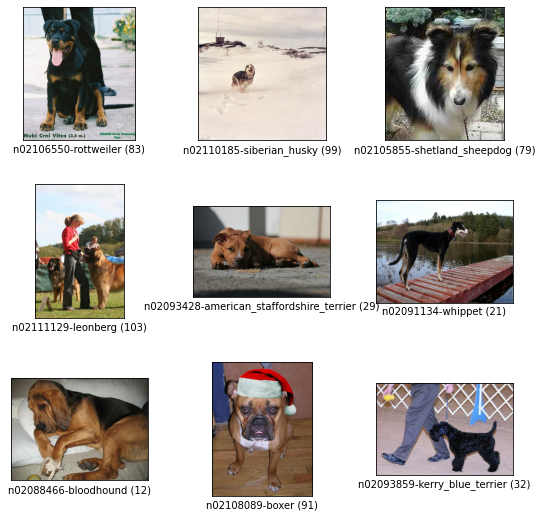

In [5]:
tfds.show_examples(ds_train, ds_info)

## 4-3. Augmentation 적용 (2) Augmentation 적용하기
텐서플로우 Random Augmentation API 사용하기

많은 augmentation 기법들이 있지만 그중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

    random_brightness()
    random_contrast()
    random_crop()
    random_flip_left_right()
    random_flip_up_down()
    random_hue()
    random_jpeg_quality()
    random_saturation()

그럼 Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍시다.

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


이미지를 변환하는 전처리 함수는 대략 다음과 같은 형태를 가지게 됩니다.

def 전처리_함수(image, label):   # 변환할 이미지와 라벨
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label

이렇게 되면 이미지 변환의 결과로 리턴 받은 이미지를 그다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리합니다. 위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있습니다. 이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.

맨 위에서 언급한 random augmentation들 중에서 random_flip_left_right()과 random_brightness()를 활용해 보겠습니다. "flip"의 경우 좌우 대칭을 해줍니다. 예컨대 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않습니다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 합니다. 여기서 상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않습니다. 또 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠습니다.

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 apply_normalize_on_dataset()로 정의하겠습니다.
여기서는 apply_normalize_on_dataset()를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다. 이때 주의해야 할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점입니다.

여러 결과를 조합하기 위한 앙상블(ensemble) 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있습니다. 이는 캐글 등의 경쟁 머신러닝에 많이 사용되지만, 지금은 개념만 알아두어도 됩니다. 아래 링크에서 test-time augmentation에 관한 설명을 참고하세요.

[TTA(test time augmentation) with 케라스](https://hwiyong.tistory.com/215)

코드에서는 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠습니다.

[tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

In [8]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


#### Random Augmentation 직접 구현하기

위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했습니다. 이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성해보세요.

In [9]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## 4-4. Augmentation 적용 (3) 비교실험 하기

이제 비교 실험을 해보도록 하겠습니다. 우리가 비교해야 하는 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다. 새로운 augmentation이 떠오르셨다면 새로운 함수로 augmentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수도 있습니다.

아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러옵니다. include_top은 마지막 fully connected layer를 포함할지 여부입니다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

![image](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-2-P-result02.png)

## 4-5. 심화 기법 (1) Cutmix Augmentation

지금부터 조금 더 복잡한 augmentation 방법을 알아보겠습니다.

첫 번째는 CutMix augmentation입니다.

[CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features  ](https://arxiv.org/pdf/1905.04899.pdf)
[Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)   
CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법입니다. 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.

아래 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타냅니다. Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다. 차에 비유하면 블렌딩 같은 방법이죠.

두 번째 링크인 Chris Deotte's CutMix and MixUp on GPU/TPU에서는 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp을 확인 할 수 있습니다. 남은 스텝에서 CutMix와 MixUp을 구현하면서 참고하도록 합시다. 참고로 캐글에서 지금 참가하고 있는 대회와 비슷한 태스크의 경진대회가 있는 경우, 다른 사람들이 적용한 방법들을 찾아보는 것도 인사이트를 얻는 데 좋습니다.

CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함합니다. 이제 한 부분씩 구현해 보겠습니다.

![image](https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-2.max-800x600.png)

#### 1) 이미지 섞기

가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해 봅시다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부릅니다.

예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 보겠습니다.

아래 코드 블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만들어 보세요! 이미지를 텐서로 만들어 텐서플로우 연산을 사용해 봅시다. 이때 이미지는 tfds에서 한 장을 뽑아서 사용해 보세요.

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

두 개의 이미지를 얻었습니다.

이 중 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 2) 라벨 섞기

이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.

CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅시다.

In [12]:
# mix two labels
#여기저기 뭔가 구멍나있다 image a b 추가
def mix_2_labels(image_a, image_b, label_a,label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

In [13]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b,label_a, label_b, x_min, y_min, x_max, y_max))
#여기저기 뭔가 구멍나있다 image a b 추가
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## 4-6. 심화 기법 (2) Mixup Augmentation

Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다. 아래 참고자료는 앞에서 본 CutMix 비교표에서 "Mixup"이라는 방법이 제안된 논문입니다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있습니다. 아래에서 직접 Mixup 함수를 구현해보세요!

[mixup:Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-2-P-3.max-800x600.png)

In [14]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [15]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!
#### 1. Augmentation을 적용한 데이터셋 만들기

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

In [16]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, 
                               batch_size=16, 
                               with_aug=False,
                               with_mixup=False,
                               with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    #CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 
    #미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
    if not is_test and with_cutmix: #테스트가 아니고 컷믹스true
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup: #테스트가 아니고 믹스업true
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else: 
        ds = ds.map(
            onehot, #원핫이 없다 one_hot함수로 만들어줘야겠다
            num_parallel_calls=2
        )

    if not is_test: #테스트가 아닐경우에만 셔플, 반복
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) #프리패치로 미리 메모리 로딩
    return ds

print('=3')

=3


In [17]:
def onehot(image, label):
    #mixup2image에서 활용을 보자
    
    num_classes = ds_info.features["label"].num_classes
    
    oh_label = tf.one_hot(label,num_classes)
    
    return image, oh_label

ex)
indices = [0, 1, 2]   
depth = 3   
tf.one_hot(indices, depth)  # output: [3 x 3]   
 [[1., 0., 0.],  
  [0., 1., 0.],  
  [0., 0., 1.]]    


#### 2. 모델 만들기

앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.
#### 3. 모델 훈련하기

모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

In [18]:
num_classes = ds_info.features["label"].num_classes
aug_list = ['original','aug','mixup','cutmix'] #글로벌 함수를 사용해서 반복을 하자

for i in aug_list:
    globals()[f'{i}_resnet50'] = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94773248/94765736 [==============================] - 1s 0us/step
=3


In [19]:
# original_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy']
# )
# original_resnet50.summary()
# #변수가 잘 생성됬나 확인하고

In [20]:
for i in aug_list:
    globals()[f'{i}_resnet50'].compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01),
        metrics=['accuracy']
    )
    globals()[f'{i}_resnet50'].summary()
#한꺼번에 만들자

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
#여기서 mixup과 cutmix는 기본 aug가 더해져있다
ds_train_original = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [22]:
import time
import datetime
from datetime import timedelta
#시간측정용

def ttime(start):
    end = time.time()
    sec = (end-start) 
    result = datetime.timedelta(seconds=sec)
    print("지난시간:",result,end="\n\n")  

In [23]:
# #EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 20
# start = time.time() #시간을 측정해보자


# history_resnet50_no_aug = resnet50.fit(
#     ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

# ttime(start)

# history_resnet50_aug = aug_resnet50.fit(
#     ds_train_aug, # augmentation 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )
# ttime(start)
#글로벌함수 반복문 이전

In [24]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20
start = time.time() #시간을 측정해보자
aug_list = ['original', #돌린게 아까워서 빼고 해본다(그러다 반쯤하고 튕김 아오)
            'aug','mixup','cutmix']

for i in aug_list:
    print(f'{i}시작')
    #글로벌 함수를 이용해서 포문에서 변수명 변경
    #ex) history_resnet50_original = original_resnet50.fit(ds_train_original)
    globals()[f'history_resnet50_{i}'] = globals()[f'{i}_resnet50'].fit(
    globals()[f'ds_train_{i}'],  
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    )
    ttime(start)
    print(f'{i}끝')
    globals()[f'{i}_resnet50'].save(f'{i}.h5') #터질까봐 저장


original시작
Epoch 1/20
750/750 [==============================] - 371s 431ms/step - loss: 3.1629 - accuracy: 0.2767 - val_loss: 3.6035 - val_accuracy: 0.1761
Epoch 2/20
750/750 [==============================] - 324s 432ms/step - loss: 0.9150 - accuracy: 0.7427 - val_loss: 1.1078 - val_accuracy: 0.6783
Epoch 3/20
750/750 [==============================] - 324s 433ms/step - loss: 0.3269 - accuracy: 0.9207 - val_loss: 0.9611 - val_accuracy: 0.7172
Epoch 4/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0857 - accuracy: 0.9898 - val_loss: 0.9063 - val_accuracy: 0.7414
Epoch 5/20
750/750 [==============================] - 324s 433ms/step - loss: 0.0317 - accuracy: 0.9986 - val_loss: 0.8946 - val_accuracy: 0.7445
Epoch 6/20
750/750 [==============================] - 324s 433ms/step - loss: 0.0167 - accuracy: 0.9999 - val_loss: 0.9136 - val_accuracy: 0.7452
Epoch 7/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0131 - accuracy: 0.9996 - val_los

750/750 [==============================] - 326s 435ms/step - loss: 1.8440 - accuracy: 0.8356 - val_loss: 1.2447 - val_accuracy: 0.6777
Epoch 17/20
750/750 [==============================] - 326s 435ms/step - loss: 1.8806 - accuracy: 0.8376 - val_loss: 1.1785 - val_accuracy: 0.6842
Epoch 18/20
750/750 [==============================] - 326s 435ms/step - loss: 1.8383 - accuracy: 0.8406 - val_loss: 1.2611 - val_accuracy: 0.6721
Epoch 19/20
750/750 [==============================] - 327s 436ms/step - loss: 1.7949 - accuracy: 0.8423 - val_loss: 1.2205 - val_accuracy: 0.6853
Epoch 20/20
750/750 [==============================] - 327s 436ms/step - loss: 1.7836 - accuracy: 0.8509 - val_loss: 1.2388 - val_accuracy: 0.6855
지난시간: 5:25:38.579663

mixup끝
cutmix시작
Epoch 1/20
750/750 [==============================] - 337s 436ms/step - loss: 4.4226 - accuracy: 0.0944 - val_loss: 3.5735 - val_accuracy: 0.1860
Epoch 2/20
750/750 [==============================] - 325s 434ms/step - loss: 3.1159 - accura

In [32]:
# #EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 20
# start = time.time() #시간을 측정해보자

# for i in aug_list:
#     print(f'{i}시작')
#     globals()[f'history_resnet50_{i}'] = globals()[f'{i}_resnet50'].fit(
#     globals()[f'ds_train_{i}'],  
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
#     )
#     ttime(start)
#     print(f'{i}끝')
# #괜히 시간함수 달았다가 하나 끝나고 터졌다 아오ㅠ
# #돌다리함수도 두드려보고 건너자 ㅠ

In [25]:
start = time.time()
ttime(start)

지난시간: 0:00:00.000087



#### 4. 훈련 과정 시각화하기

훈련 과정의 히스토리를 그래프로 시각화해 주세요.

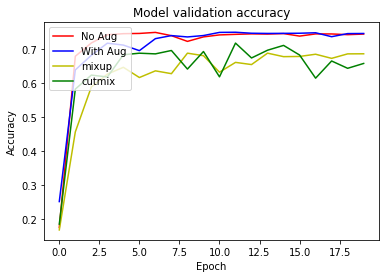

In [28]:
plt.plot(history_resnet50_original.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug','mixup','cutmix'], loc='upper left')
plt.show()

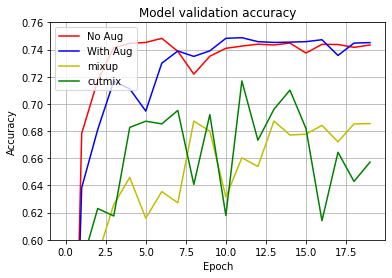

In [33]:
plt.plot(history_resnet50_original.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug','mixup','cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

#### 5. Augmentation에 의한 모델 성능 비교

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

## 비교

음 이상하게도 컷믹스랑 믹스업은 학습을 방해하기만 한걸로 보인다    
특히 컷믹스는 정확도가 널뛴다   
통상의 augment는 향상을 보였으나 아주 그 향상치가 적었다

## 이미지 증강 타입별 정확도와 손실(20epoch)

Augment|val_loss|val_acu
:-|:-|:-
original| 1.0092  | 0.7434
aug| 1.0161  | 0.7451
mixup| 1.2388  | 0.6855
cutmix| 1.4165  | 0.6572

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

No.|평가문항|	상세기준|
-|:-|:-
1.|CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|	CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2.| 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함
3.| 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|	기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

##  회고
음 내가 잘못 만든건지 컷믹스랑 믹스업은 실패. 일반적인 증강도 비슷한 결과를 보였다   
오래걸린다. 함수 기능이 덜 구현되어있어 알아서 보수를 해야한다. 공부가 된다
- onehot함수가 없었지만 tf.one_hot함수로 구현
- mix2label에서 파라미터가 image_a image_b가 없어서 터져서 보수
- 괜히 시간잰다고 임포트 안하고 전의 코드 갖다썻다가 1시간 반후 터짐
- 코드 줄일겸 반복해서 타이핑하기 싫어서 글로벌함수로 구현. 뿌듯하긴한데 가독성이..
- 조언을 듣고 model.save()로 저장 (저장하니 안터져서 쓰진 않았음)
